In [1]:
import numpy as np
#from math import sin, cos, sqrt

def deriv_send(xdot, x):
    rho=25
    sigma=10
    beta=1.5
    xdot[0]=sigma * (x[1] - x[0])
    xdot[1]=x[0] * rho - x[1] - x[0] * x[2]
    xdot[2]=x[0] * x[1] - beta * x[2]
    return 0

def deriv_receive(xdot, x, xp):
    rho=25
    sigma=10
    beta=1.5
    xdot[0]=sigma * (x[1] - x[0])
    xdot[1]=xp * rho - x[1] - xp * x[2]
    xdot[2]=xp * x[1] - beta * x[2]
    return 0

def rkm_send(h, x, N):
    xdot0 = np.zeros(N, dtype=np.float64)
    xdot1 = np.zeros(N, dtype=np.float64)
    xdot2 = np.zeros(N, dtype=np.float64)
    xdot3 = np.zeros(N, dtype=np.float64)
    g = np.zeros(N, dtype=np.float64)
    
    hh = h * 0.5
    deriv_send(xdot0, x)
    for i in range(N):
        g[i] = x[i] + hh * xdot0[i]
        
    deriv_send(xdot1, g)
    for i in range(N):
        g[i] = x[i] + hh * xdot1[i]
        
    deriv_send(xdot2, g)
    for i in range(N):
        g[i] = x[i] + h * xdot2[i]
        
    deriv_send(xdot3, g)
    for i in range(N):
        x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                           (xdot1[i] + xdot2[i]) + 
                           xdot3[i]) / 6.0
    return 0

def rkm_receive(h, x, xp, N):
    xdot0 = np.zeros(N, dtype=np.float64)
    xdot1 = np.zeros(N, dtype=np.float64)
    xdot2 = np.zeros(N, dtype=np.float64)
    xdot3 = np.zeros(N, dtype=np.float64)
    g = np.zeros(N, dtype=np.float64)
    
    hh = h * 0.5
    deriv_receive(xdot0, x, xp)
    for i in range(N):
        g[i] = x[i] + hh * xdot0[i]
    
    deriv_receive(xdot1, g, xp)
    for i in range(N):
        g[i] = x[i] + hh * xdot1[i]
        
    deriv_receive(xdot2, g, xp)
    for i in range(N):
        g[i] = x[i] + h * xdot2[i]
        
    deriv_receive(xdot3, g, xp)
    for i in range(N):
        x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                           (xdot1[i] + xdot2[i]) + 
                           xdot3[i]) / 6.0
        
    return 0


def chaos_commn(N = 3 , nosdata = 40000):
    xt = np.zeros(nosdata, dtype=np.float64)
    xr = np.zeros(nosdata, dtype=np.float64)
    signal = np.zeros(nosdata, dtype=np.float64)
    recovered = np.zeros(nosdata, dtype=np.float64)
    encryptedx = np.zeros(nosdata, dtype=np.float64)
        
    tstep = 0.0001
    ndrop = 15000
    xold = np.random.uniform(0, 1, size=N)
    print xold
    
    for i in range(ndrop):
        rkm_send(tstep, xold, N)
        
    for i in range(nosdata):
        rkm_send(tstep, xold, N)
        xt[i] = xold[0]
        
    signal = np.random.uniform(-1, 1, size=nosdata)
    #for i in range(nosdata):
    #    signal[i] = (1.5 * sin(0.01 * i) + 
    #                 1.0 * sin(0.01 * sqrt(2.0) * i))
        
    for i in range(nosdata):
        encryptedx[i] =  signal[i] + xt[i]
    
    
    xold = np.random.uniform(0, 1, size=N)
    print xold
    for i in range(ndrop):
        rkm_send(tstep, xold, N)
        
    for i in range(nosdata):
        rkm_receive(tstep, xold, encryptedx[i], N)
        xr[i] = xold[0]
        
    for i in range(nosdata):
        recovered[i] = encryptedx[i] - xr[i]
        
    return (signal, encryptedx, recovered, xt, xr)

In [2]:
signal, encryptedx, recovered, xt, xr = chaos_commn()
print signal
print encryptedx
print recovered

[ 0.56774839  0.77673221  0.77611996]
[ 0.39895623  0.6888543   0.31688597]
[ 0.93737936 -0.34891875 -0.26447923 ...,  0.98274694  0.74996839
  0.78434945]
[ -8.89429533 -10.18163801 -10.09823952 ...,  -7.72134165  -7.95661213
  -7.92472161]
[ 0.62407176 -0.66117031 -0.57567379 ...,  0.98569503  0.75289937
  0.78726311]


Populating the interactive namespace from numpy and matplotlib


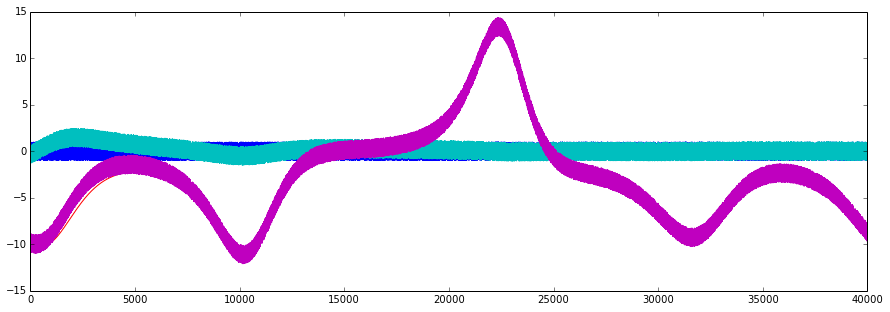

In [3]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
x = range(len(signal))

plt.figure(figsize=(15, 5))

plt.plot(x,signal)
plt.plot(x,xt)
plt.plot(x,xr)
plt.plot(x,recovered)
plt.plot(x,encryptedx)
plt.show()

Populating the interactive namespace from numpy and matplotlib


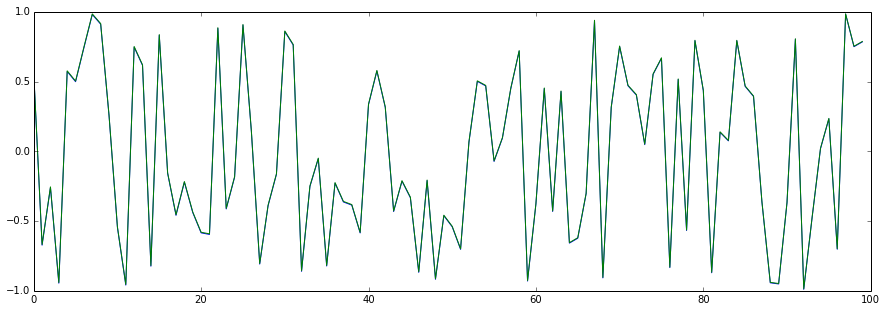

In [4]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
s = signal[-100:]
r = recovered[-100:]
x = range(len(s))

plt.figure(figsize=(15, 5))

plt.plot(x,s)
plt.plot(x,r)
plt.show()

In [5]:
def filter(encrypted, a): #dt, RC, N):    
    N = len(encrypted)
    y = np.zeros(N, dtype=np.float64)
    #a = 0.1 #RC / (RC + dt)
    y[0] = x[0]
    for i in range(1,N):
        y[i] = a * (y[i-1] + encrypted[i] - encrypted[i-1])
    return y

Populating the interactive namespace from numpy and matplotlib


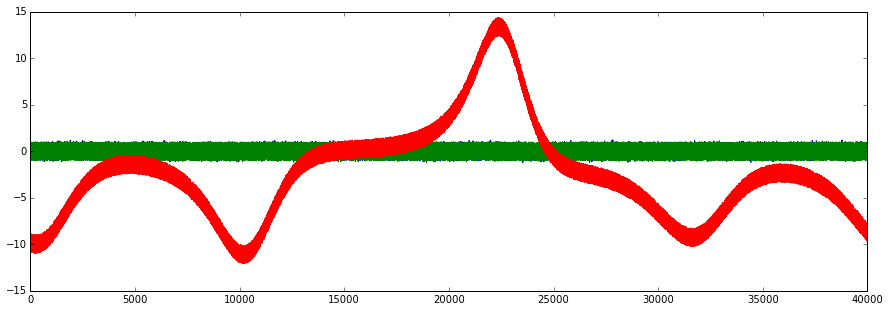

In [6]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
x = range(len(signal))
#r0 = filter(encryptedx, 0.993)
r0 = filter(encryptedx, 0.8)
plt.figure(figsize=(15, 5))

plt.plot(x,r0)
plt.plot(x,signal)
plt.plot(x,encryptedx)
plt.show()

Populating the interactive namespace from numpy and matplotlib


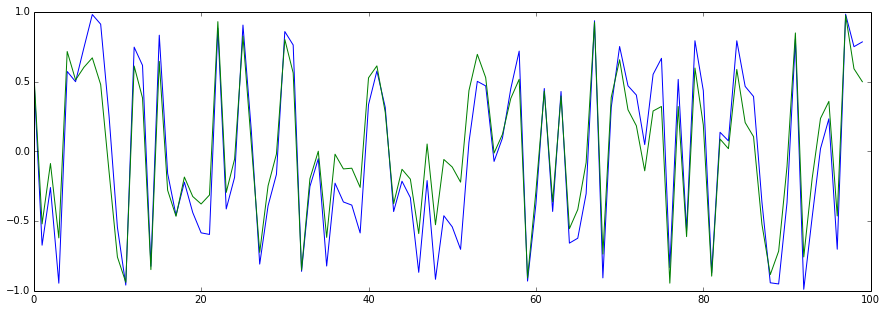

In [7]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
s = signal[-100:]
r = r0[-100:]
x = range(len(s))

plt.figure(figsize=(15, 5))

plt.plot(x,s)
plt.plot(x,r)
plt.show()

In [14]:
size = 4000
carrier = np.random.uniform(-1, 1, size=size)
signal = np.random.uniform(-1, 1, size=size)
for i in range(size):
    signal[i] = (1.0 * sin(0.001 * i))
encrypted = carrier + signal

Populating the interactive namespace from numpy and matplotlib


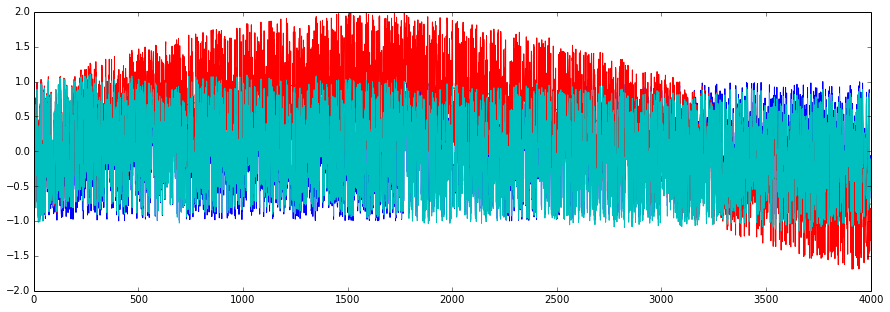

In [31]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
x = range(len(signal))

r = filter(encrypted, 1.0)
plt.figure(figsize=(15, 5))

plt.plot(x,carrier)
plt.plot(x,signal)
plt.plot(x,encrypted)
plt.plot(x, r)
plt.show()